In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

# Introduction

Welcome to a new notebook to tackle a new playground series competition. This notebooks attempts to provide goood introductory EDA with some recommendations before modeling.

Thanks for reading. Don't forget to upvote if you find it useful.

* v1: inital commit
* v2: added baseline and outliers EDA
* v3: added LGBMRegressor with clip post_processing
* v4: added some feature engineering
* v5: added a custom class that incorporates rounder -> see Regression Baseline

# Library Import

Some library import and some configurations of matplotlib.

In [2]:
from time import time
from datetime import timedelta
from colorama import Fore, Style

import math
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import lightgbm as lgbm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

warnings.simplefilter("ignore", UserWarning)

# The Data

The dataset was generated using [Wine Quality dataset](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset). The task is to predict the right `Quality` which is an ordinal column.

Some key aspects are:

* Feature distributions are close to, but not exactly the same, as the original.
* We can use the original dataset as part of data augmentation.
* It is a fairly light dataset, so we can use lots of algorithms.
* The problem is framed as an ordinal regression, altough it can be framed as a classification problem.

Columns description [taken from this link](https://archive.ics.uci.edu/ml/datasets/wine+quality):

Number of Attributes: 11 + output attribute
Input variables (based on physicochemical tests):
- `fixed acidity` (tartaric acid - $g/dm^3$) most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
- `volatile acidity` (acetic acid - $g/dm^3$) the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
- `citric acid` ($g/dm^3$) found in small quantities, citric acid can add ‘freshness’ and flavor to wines
- `residual sugar` ($g/dm^3$) the amount of sugar remaining after fermentation stops, it’s rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
- `chlorides` (sodium chloride - $g/dm^3$) the amount of salt in the wine
- `free sulfur dioxide` ($mg/dm^3$) the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
- `total sulfur dioxide` ($mg/dm^3$) amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
- `density` ($g/cm^3$) the density of water is close to that of water depending on the percent alcohol and sugar content
- `pH` describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
- `sulphates` (potassium sulphate - $g/dm^3$) a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
- `alcohol` (% by volume) the percent alcohol content of the wine

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv', index_col=0)
test_df = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv', index_col=0)

# load original dataset
original_df = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')

train_df.columns = train_df.columns.str.replace(' ', '_')
original_df.columns = original_df.columns.str.replace(' ', '_')
test_df.columns = test_df.columns.str.replace(' ', '_')

features = train_df.columns[:-1]

# The Label


Train and original follows the same distribution of Quality. The order percentage of observations and the order of qualities categories is almost the same, this is good in the sense we can incorporate original data as part of our models. Quality 3 doesn't have lots of records, so this may by a problem when selecting a CV strategy as it may not be included.

**Insights**
- StratifiedKFold is recommended as the initial cross validations strategy.

In [4]:
print('Train')
display(train_df.quality.value_counts(True))

print('\nOriginal')
display(original_df.quality.value_counts(True))

Train


5    0.408074
6    0.378405
7    0.161965
4    0.026751
8    0.018969
3    0.005837
Name: quality, dtype: float64


Original


5    0.422572
6    0.404199
7    0.125109
4    0.028871
8    0.013998
3    0.005249
Name: quality, dtype: float64

# EDA

## Data Size

**Insights**:
- This a fairly light dataset, we can use several models, ensembles, feature engineering and multiple tricks without lots of computational power.
- Original dataset has less records that synthetic dataset.

In [5]:
print('Train shape:            ', train_df.shape)
print('Test shape:             ', test_df.shape)
print('Original Dataset shape: ', original_df.shape)

Train shape:             (2056, 12)
Test shape:              (1372, 11)
Original Dataset shape:  (1143, 13)


# Distributions

The importance of inspecting the distribution of data cannot be overstated, as it provides insight into potential anomalies in the variables and the necessity for preprocessing techniques. The next section will use common plots to show relationships between the features, the target and some discrepancies between synthetic and original dataset.

# Train Vs Test vs Original

**Insights**:

- At first glance the only discernable difference lies in the distribution of free sulfur dioxide `free sulfur dioxide`. On the other hand train and test datasets does not reveal any substantial variations, suggesting that there is no need to conduct an extensive adversarial validation..
- The distributions of `Chlorides` and `residual sugars` exhibit a skewed pattern, which may require rectification through the use of the clip function. This technique can be especially beneficial for machine learning models that rely on feature scaling, as it can mitigate the impact of outliers on model performance.
- Concating original dataset is a good idea in this problem.

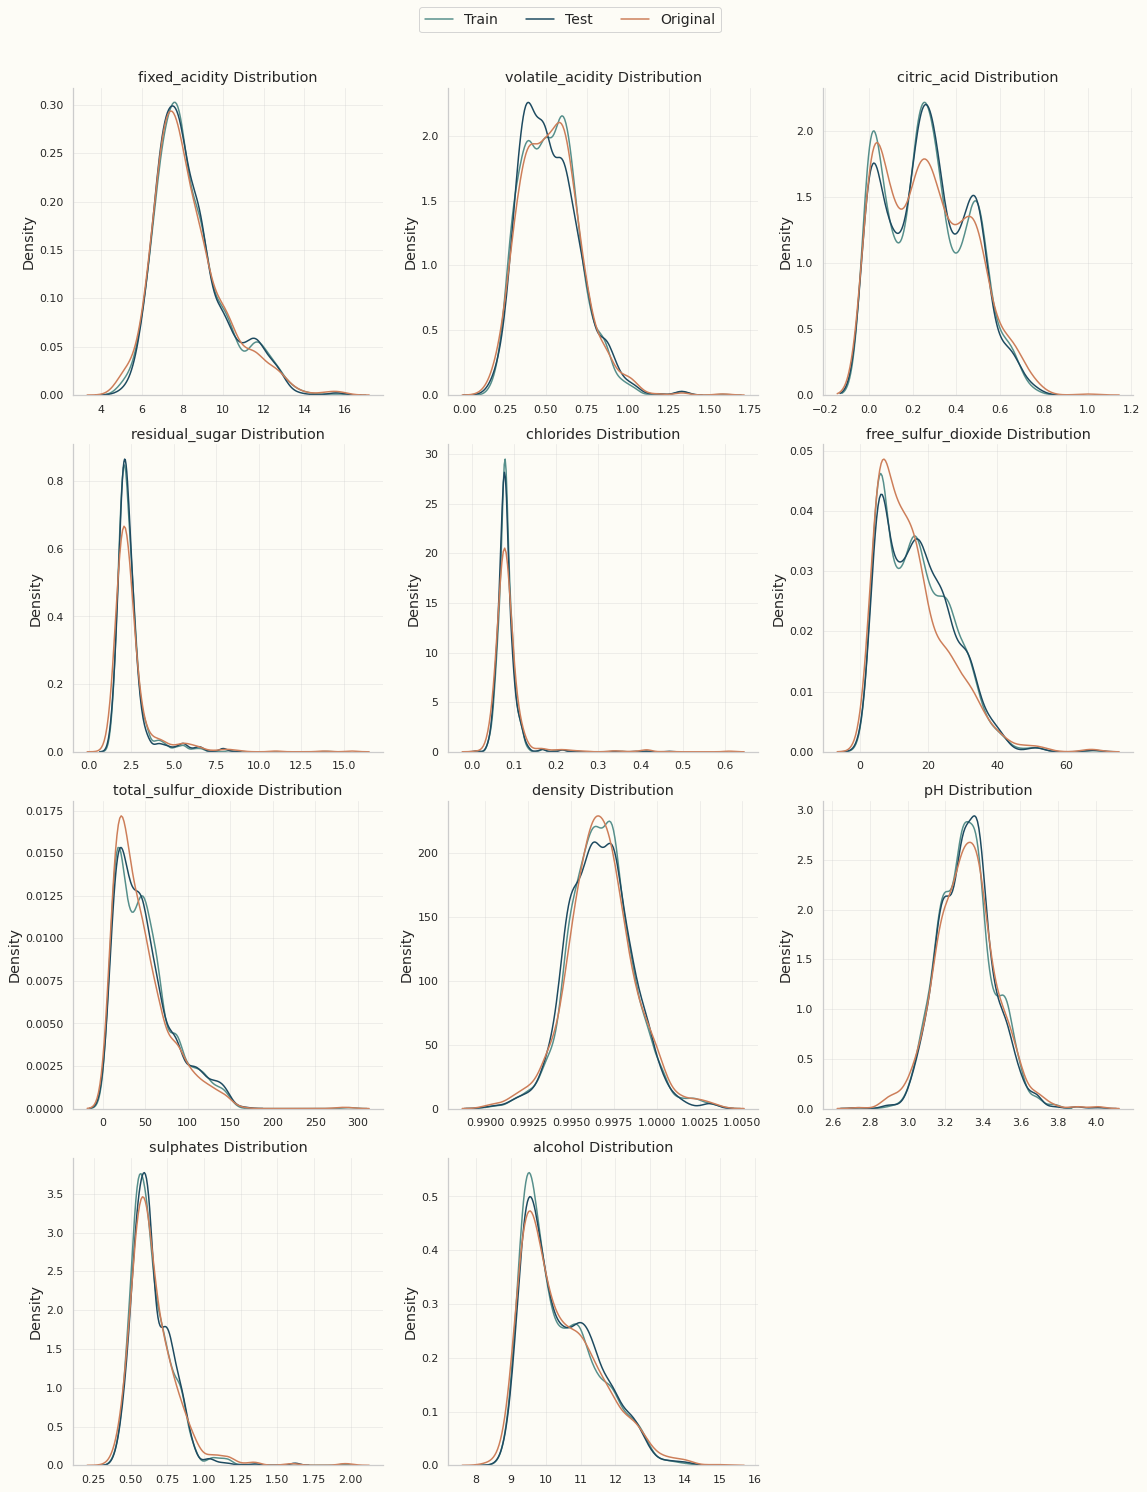

In [6]:
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.kdeplot(
        train_df[column], label='Train',
        ax=ax[i], color=colors[1]
    )
    
    sns.kdeplot(
        test_df[column], label='Test',
        ax=ax[i], color=colors[2]
    )
    
    sns.kdeplot(
        original_df[column], label='Original',
        ax=ax[i], color=colors[3]
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=3)
plt.tight_layout()

# Features vs Label Distribution

**Insights**:

- The features in the dataset exhibit distinct variations across different categories, which is in line with the expectations that better quality wines are subjected to unique conditions. 
- The variables `Chlorides` and `free sulfur Dioxide` are expected to have a significant influence on the prediction of quality 3 wines.



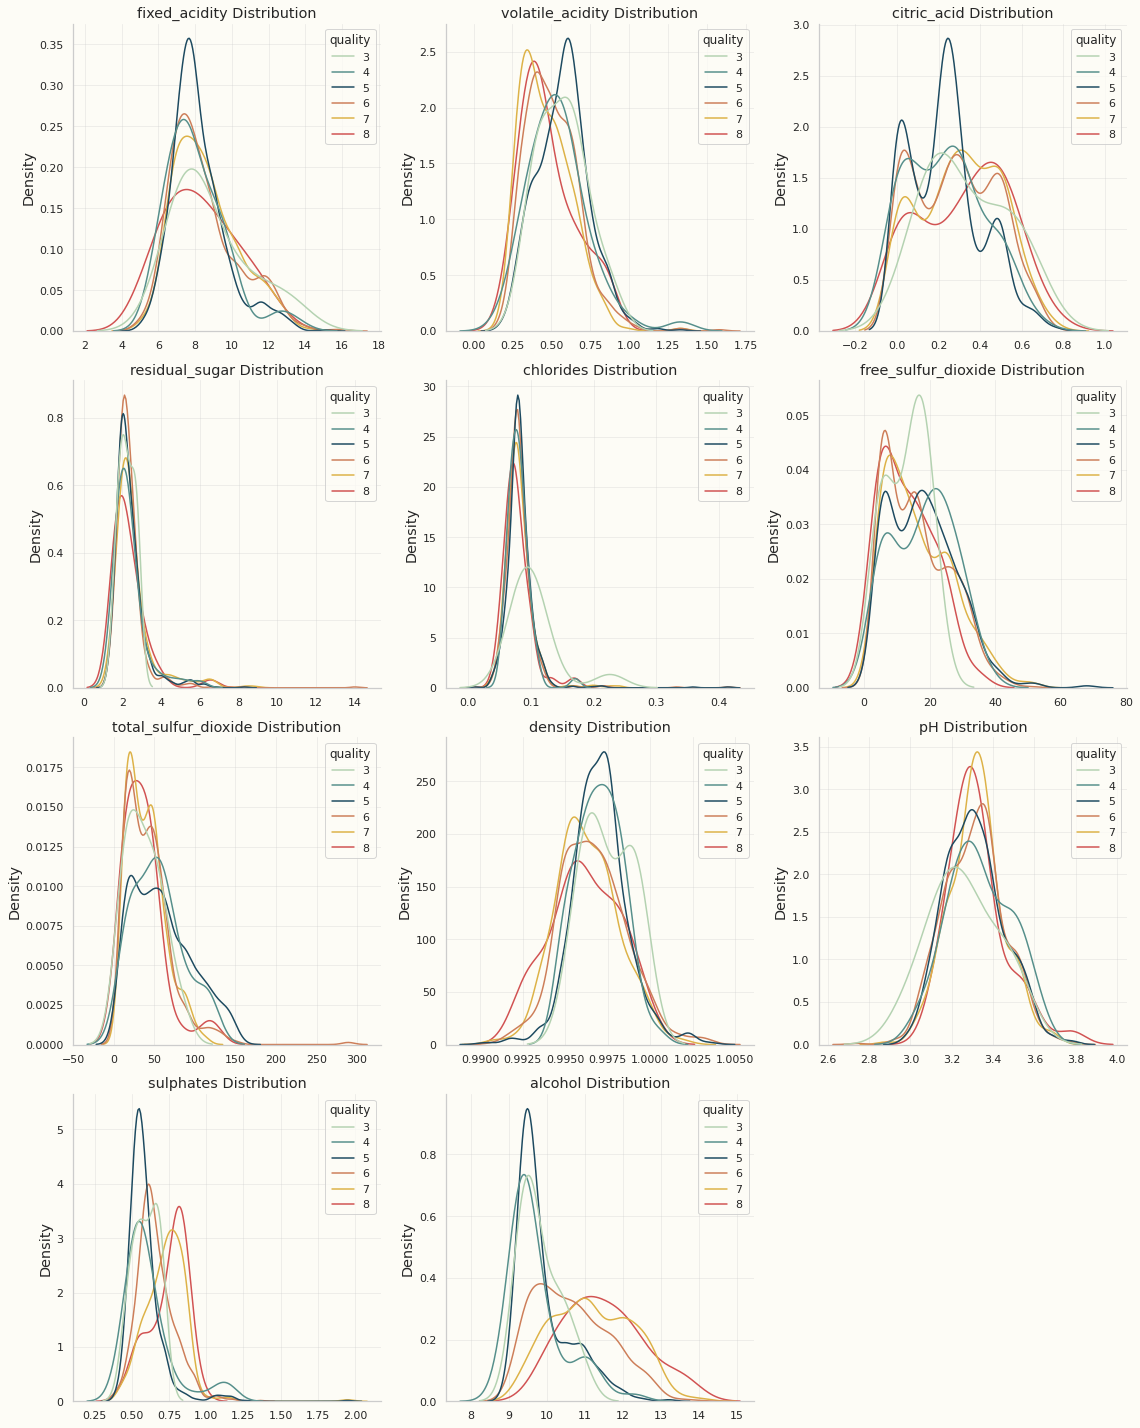

In [7]:
columns = features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.kdeplot(
        train_df[column],
        hue=train_df.quality,
        ax=ax[i],
        common_norm=False,
        palette=palette_rgb
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

plt.tight_layout()

# Box plots

Boxplots summarize key features of a dataset, including outliers, central tendency, distribution shape, and group comparisons. They are a valuable tool for exploratory data analysis, helping to quickly identify important features of the data.

**Insights**:

- Two features, `alcohol` and `sulphates`, have been identified as having a linear relationship with wine quality. This suggests that as the concentration of alcohol and sulphates in a wine increases, the quality of the wine tends to improve.
- On the other hand, `density` and `volatile acidity` has been identified as having an inverse relationship with wine quality. This suggests that as the density of a wine increases, the quality of the wine tends to decrease.
- Qualities 5 and 6 have more outliers than the rest of the categories. Maybe to clip features is a bad idea and it's better to either add an indicator feature or to use tree-based models.



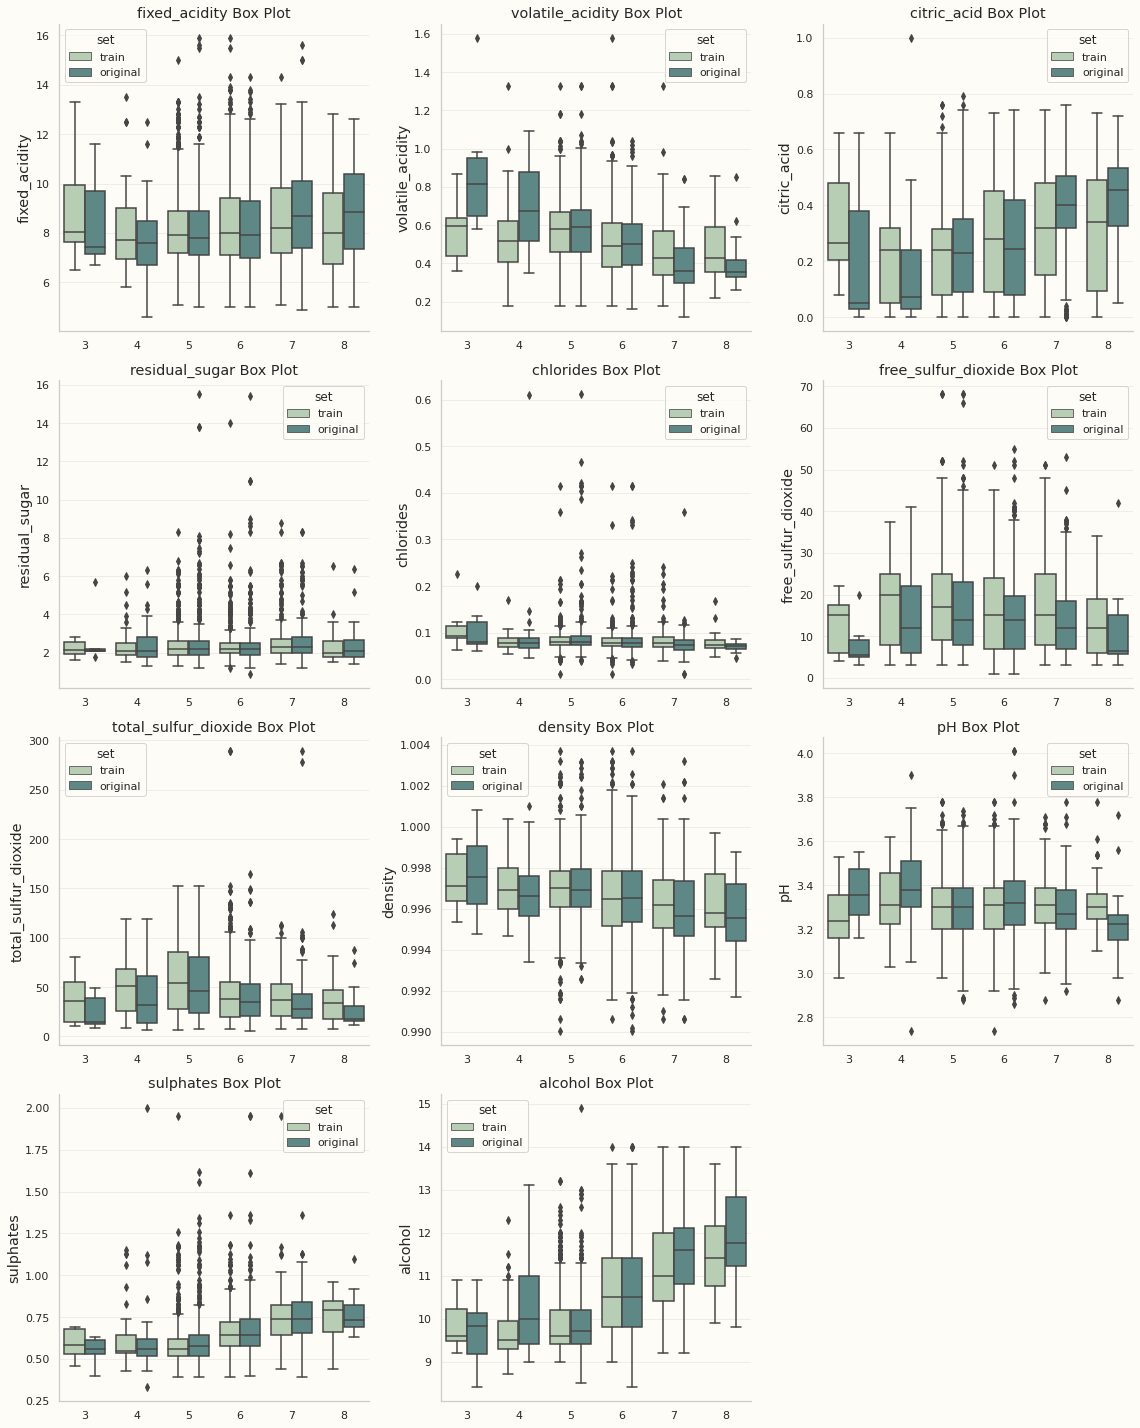

In [8]:
columns = features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

total_df = pd.concat([train_df, original_df], axis=0)
total_df['set'] = 'original'
total_df.iloc[:train_df.shape[0], -1]  = 'train'
total_df.drop(columns='Id', inplace=True)

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.boxplot(
        y=total_df[column],
        x=total_df.quality,
        hue=total_df.set,
        ax=ax[i],
    )
    
    # titles
    ax[i].set_title(f'{column} Box Plot');
    ax[i].set_xlabel(None)
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

plt.tight_layout()

# Outliers


The plot shows the results of counting all records in each group that have a z-score with an absolute value greater than 2, indicating outliers (observations more than 2 standard deviations from the mean).

**Insights**
- The retention of outliers is essential for accurately identifying values 5, 6, and 7 in features such as `volatile acidity`, `citric acid`, and `density`. 
- In the other groups, the number of outliers is limited, and if the joint distributions per class are distinct, a basic linear model such as linear discriminant analysis (LDA) can be of great help.



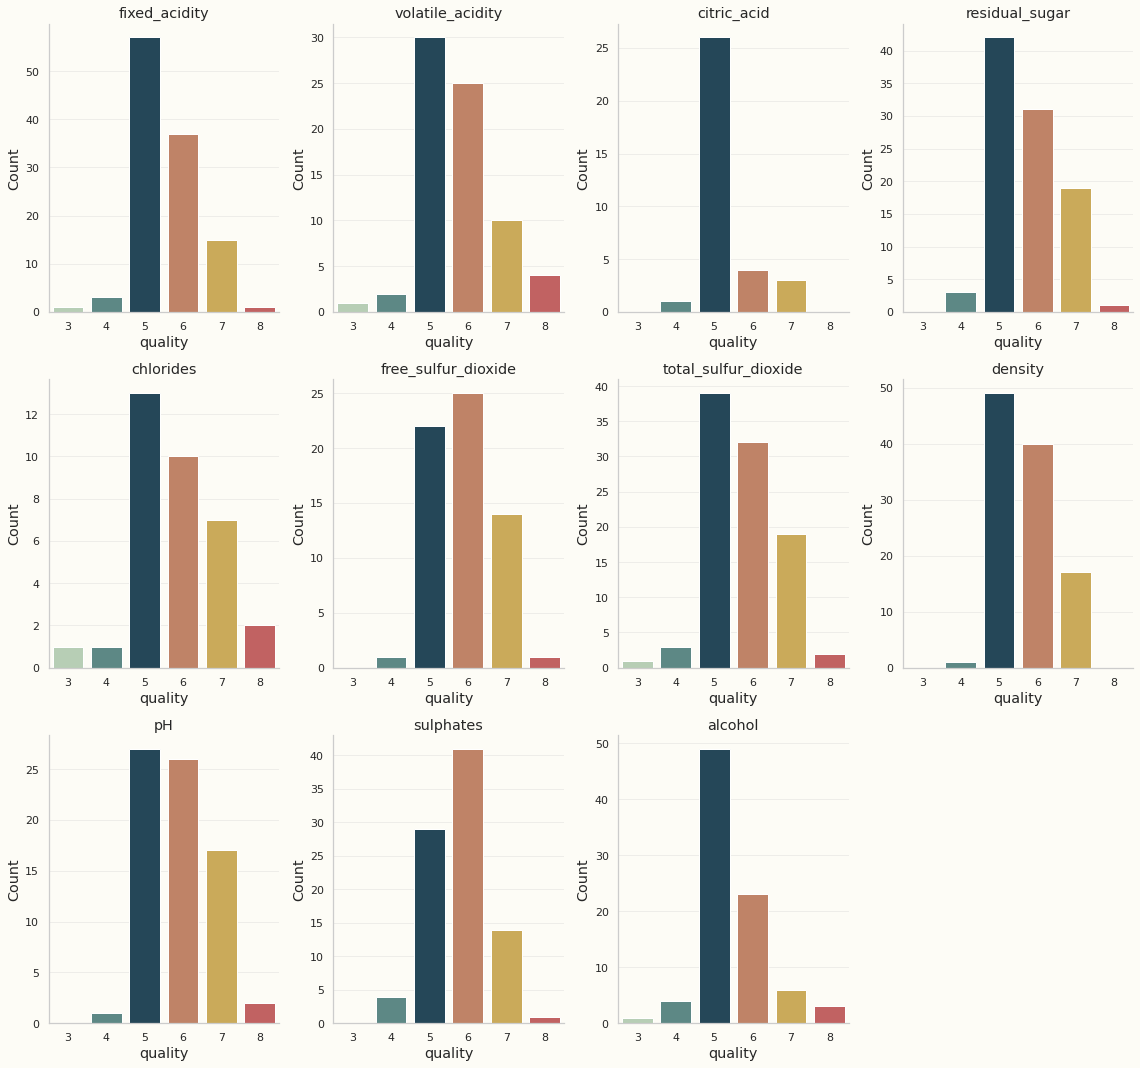

In [9]:
from scipy.stats import zscore

features = train_df.columns[:-1]
z_scores = train_df[features]
z_scores = z_scores.groupby(train_df.quality).apply(zscore)
outliers = z_scores.abs().ge(2).groupby(train_df.quality).sum()

n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, feature in enumerate(features):
    sns.barplot(x=outliers.index, y=outliers[feature], ax=ax[i])
    ax[i].set_ylabel('Count')
    ax[i].set_title(feature)
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
plt.tight_layout()

# Missing Values

**Insights**
- There are no null values, this competition won't involve any null filling technique. We can use directly any model out of the box.

In [10]:
train_null = train_df.isnull().sum().rename('train')
test_null = test_df.isnull().sum().rename('test')
original_null = original_df.isnull().sum().rename('original')

pd.concat([train_null, test_null, original_null], axis=1)

,train,test,original
fixed_acidity,0.0,0.0,0
volatile_acidity,0.0,0.0,0
citric_acid,0.0,0.0,0
residual_sugar,0.0,0.0,0
chlorides,0.0,0.0,0
free_sulfur_dioxide,0.0,0.0,0
total_sulfur_dioxide,0.0,0.0,0
density,0.0,0.0,0
pH,0.0,0.0,0
sulphates,0.0,0.0,0


# Correlations

**Insights**:
- Correlations from train and original datasets are different.
- Pairwise correlation between features and `Quality` are similar between train and original dataset.

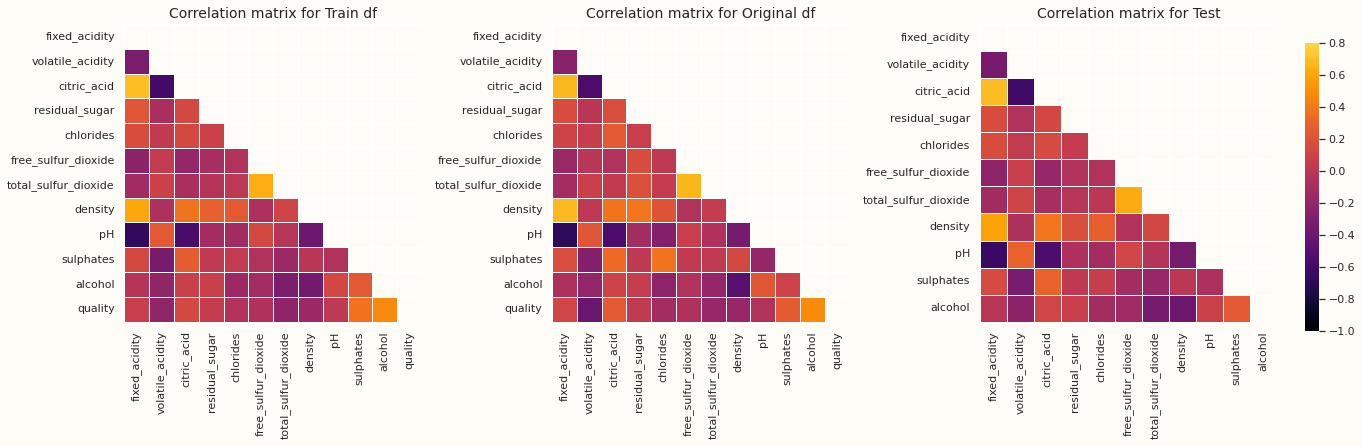

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
float_types = [np.int64, np.float16, np.float32, np.float64]
float_columns = train_df.select_dtypes(include=float_types).columns
cbar_ax = fig.add_axes([.91, .39, .01, .2])

names = ['Train', 'Original']
for i, df in enumerate([train_df, original_df]):
    
    corr = df[float_columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr, mask=mask, cmap='inferno',
        vmax=0.8, vmin=-1,
        center=0, annot=False, fmt='.3f',
        square=True, linewidths=.5,
        ax=ax[i],
        cbar=False,
        cbar_ax=None
    );

    ax[i].set_title(f'Correlation matrix for {names[i]} df', fontsize=14)

df = test_df
float_columns = test_df.select_dtypes(include=float_types).columns
corr = test_df[float_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, mask=mask, cmap='inferno',
    vmax=0.8, vmin=-1,
    center=0, annot=False, fmt='.3f',
    square=True, linewidths=.5,
    cbar_kws={"shrink":.5, 'orientation':'vertical'},
    ax=ax[2],
    cbar=True,
    cbar_ax=cbar_ax
);
ax[2].set_title(f'Correlation matrix for Test', fontsize=14)
fig.tight_layout(rect=[0, 0, .9, 1]);

# Feature Engineering

To improve the performance of a model it is important to develop good features. To make good feature engineering it is important to perform a good EDA and familiarize yourself with the problem to extract good relationship between the features and the target variable. The insights gained from procedure allows us to create new features that better capture more complex relationships.

This are some ideas I got from watching the previous plots, the more different each box plot it, the better for the model.

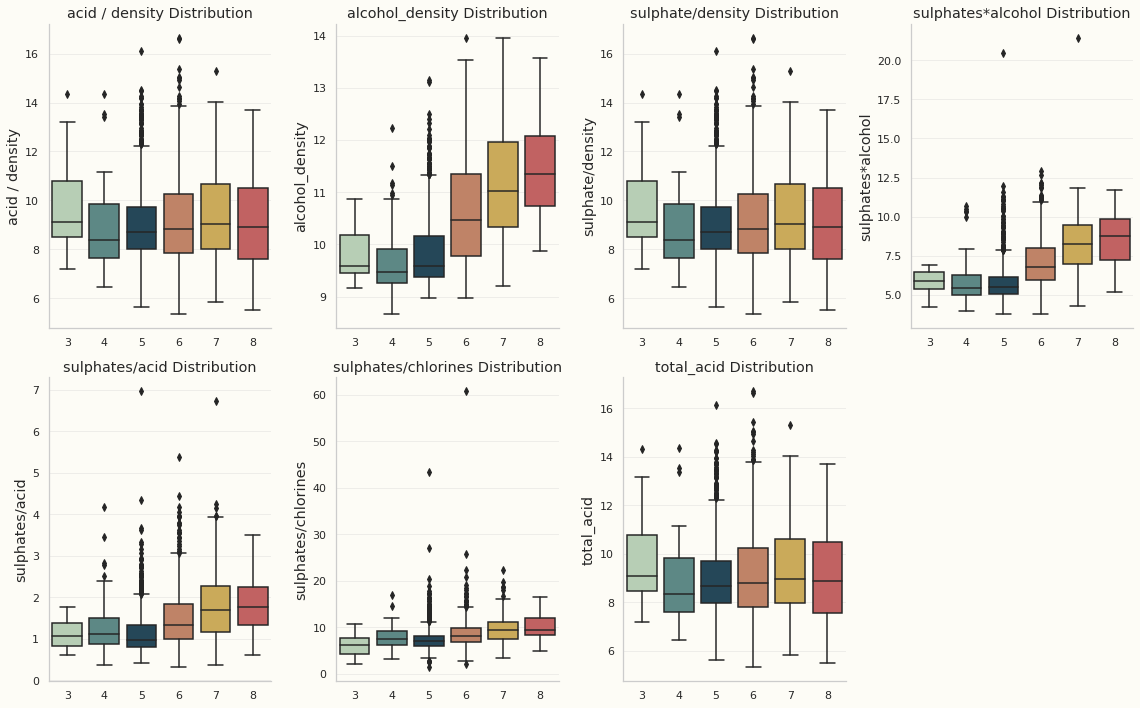

In [12]:
def FE(X):
    X['total_acid'] = X['fixed_acidity'] + X['volatile_acidity'] + X['citric_acid']
    X['acid / density'] = X['total_acid']  / X['density']
    X['alcohol_density'] = X['alcohol']  * X['density']
    X['sulphate/density'] = X['total_acid']  / X['density']
    X['sulphates/acid'] = X['sulphates'] / X['volatile_acidity']
    X['sulphates/chlorines'] = X['sulphates'] / X['chlorides']
    X['sulphates*alcohol'] = X['sulphates'] * X['alcohol']
    return X

X = train_df.copy()
X = FE(X)
new_cols = X.columns.difference(train_df.columns)

columns = new_cols
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.boxplot(
        y=X[column],
        x=X.quality,
        ax=ax[i],
        palette=palette_rgb
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

plt.tight_layout()

# The most Basic Baseline

In the next code I'll show how to setup a cross validation scheme and concat the original dataframe on each fold.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

cv = StratifiedKFold(5, shuffle=True, random_state=42)
X = train_df[features]
y = train_df.quality

kappas = []
test_preds = []
models = []
oof_preds = pd.Series(0, index=train_df.index)
start = time()

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, train_df.quality)):
    start_fold = time()
    X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
    
    # concat orginal df
    X_tr = pd.concat([X_tr, original_df[features]])
    y_tr = pd.concat([y_tr, original_df.quality])
    
    X_tr = FE(X_tr)
    X_vl = FE(X_vl)
    
    model = LGBMClassifier(max_depth=4, random_state=42, class_weight='balanced')
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_vl)
    oof_preds.iloc[vl_ix] = y_pred
    kappas.append(cohen_kappa_score(y_vl, y_pred, weights='quadratic'))
    models.append(model)
    
    print('_' * 30)
    print(f'Fold: {fold} - {timedelta(seconds=int(time()-start))}')
    print(f'Quadratic Kappa  : ', kappas[-1])
    print(f'Train Time taken :  {timedelta(seconds=int(time()-start_fold))}')
    print()
    
print(f'Mean Quadratic Kappa:  {Fore.GREEN}{np.mean(kappas)}{Style.RESET_ALL}')

______________________________
Fold: 0 - 0:00:00
Quadratic Kappa  :  0.43988669585106877
Train Time taken :  0:00:00

______________________________
Fold: 1 - 0:00:00
Quadratic Kappa  :  0.5290550008758101
Train Time taken :  0:00:00

______________________________
Fold: 2 - 0:00:01
Quadratic Kappa  :  0.465192989950047
Train Time taken :  0:00:00

______________________________
Fold: 3 - 0:00:01
Quadratic Kappa  :  0.47148951051498467
Train Time taken :  0:00:00

______________________________
Fold: 4 - 0:00:02
Quadratic Kappa  :  0.5295525494276796
Train Time taken :  0:00:00

Mean Quadratic Kappa:  0.487035349323918


# Regression

This problem can also be framed a regression task because quality is an ordered collection of classes. Just make sure to round your predction to the nearest integer a clip them between 3 and 8. Please refer to this [discussion](https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382525) for more information.

## Integration with Rounder
In the aformetion discussion, there is a link pointing to custom rounder method that can increse the scores of your model. In this [discussion](https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382960), I found a good motivatin to integrate the regressor with the rounder as it may help with the integration of the model with Sklearn. See the code below for more info.

In [14]:
from lightgbm import LGBMRegressor
import scipy as sp
from functools import partial

qwk = partial(cohen_kappa_score, weights='quadratic')
class LGBMRegressorWithRounder(LGBMRegressor):
    '''
    A light wrapper over LGBMRegressor to deal with the usual problems.
    '''
    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8

        ll = qwk(y, X_p)
        return -ll
    
    def fit(self, X, y, **params):
        super().fit(X, y, **params)
        X_pred = super().predict(X)
        loss_partial = partial(self._kappa_loss, X=X_pred, y=y)
        # a little bit of wobble
        initial_coef = list(
            np.array([3.5, 4.5, 5.5, 6.5, 7.5])
        )
        self.round_coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        return self
    
    def set_params(self, **params):
        self.round_coef_ = None
        
    def predict_discrete(self, X):
        coef = self.coefficients()
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8
        return X_p.astype('int')

    def coefficients(self):
        return self.round_coef_['x']
    
    def predict(self, X):
        X_pred = super().predict(X)
        return self.predict_discrete(X_pred)

## Regressor Baseline

In [15]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)
X = train_df[features]
y = train_df.quality

kappas = []
test_preds = []
models = []
oof_preds = pd.Series(0, index=train_df.index)
start = time()

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, train_df.quality)):
    start_fold = time()
    X_tr, y_tr = X.loc[tr_ix], y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix], y.loc[vl_ix]
    
    # concat orginal df
    X_tr = pd.concat([X_tr, original_df[features]])
    y_tr = pd.concat([y_tr, original_df.quality])
    
    X_tr = FE(X_tr)
    X_vl = FE(X_vl)
    
    model = LGBMRegressorWithRounder(max_depth=4, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_vl)
    oof_preds.iloc[vl_ix] = y_pred
    kappas.append(cohen_kappa_score(y_vl, y_pred, weights='quadratic'))
    models.append(model)
    
    print('_' * 30)
    print(f'Fold: {fold} - {timedelta(seconds=int(time()-start))}')
    print(f'Quadratic Kappa  : ', kappas[-1])
    print(f'Train Time taken :  {timedelta(seconds=int(time()-start_fold))}')
    print()
    
print(f'Mean Quadratic Kappa:  {Fore.GREEN}{np.mean(kappas)}{Style.RESET_ALL}')

______________________________
Fold: 0 - 0:00:02
Quadratic Kappa  :  0.5191173579712995
Train Time taken :  0:00:02

______________________________
Fold: 1 - 0:00:03
Quadratic Kappa  :  0.5368944642237445
Train Time taken :  0:00:01

______________________________
Fold: 2 - 0:00:05
Quadratic Kappa  :  0.5378509772794919
Train Time taken :  0:00:02

______________________________
Fold: 3 - 0:00:07
Quadratic Kappa  :  0.5662817672812266
Train Time taken :  0:00:01

______________________________
Fold: 4 - 0:00:09
Quadratic Kappa  :  0.5485388965110465
Train Time taken :  0:00:01

Mean Quadratic Kappa:  0.5417366926533618


# Confusion Matrix

LGBM is making lots of mistakes trying to separate class 5 from class 6, we could just train a model to separate this two classe and use it in a second step stacking. Class 3 is incorrectly classified all the times.

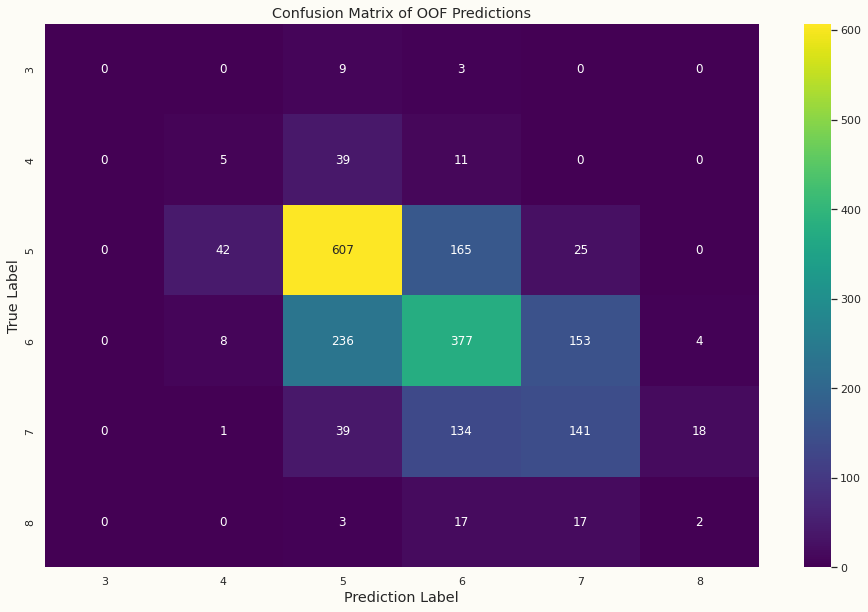

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(
    confusion_matrix(train_df.quality, oof_preds),
    annot=True,
    cmap='viridis',
    fmt='',
    ax=ax
);

qualities = np.sort(train_df.quality.unique())
ax.set_xticklabels(qualities)
ax.set_yticklabels(qualities)
ax.set_ylabel('True Label')
ax.set_xlabel('Prediction Label')
ax.set_title('Confusion Matrix of OOF Predictions');

# Submit Predictions

In [17]:
# Generate fold prediction
test_preds = {i: model.predict(FE(test_df)) for i, model in enumerate(models)}
test_preds = pd.DataFrame(test_preds)

# Set the correct index
test_preds.set_index(test_df.index, inplace=True)

# Use the mode as ensembling
test_preds = test_preds.mode(axis=1)[0].astype(int)
test_preds.rename('quality', inplace=True)
test_preds.to_csv('submssion.csv')